#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 4.7 MB/s 
     |████████████████████████████████| 125 kB 62.9 MB/s 
     |████████████████████████████████| 512 kB 59.2 MB/s 


Скачаем данные

In [2]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 18 10:26 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


Посмотрим как выглядит один из файлов разметки

In [3]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [4]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [5]:
def which_cell(x, y, S=4):
  x_c, y_c = int(x / (1/S)), int(y / (1/S))
  return x_c*S + y_c
which_cell(0.74, .3)

9

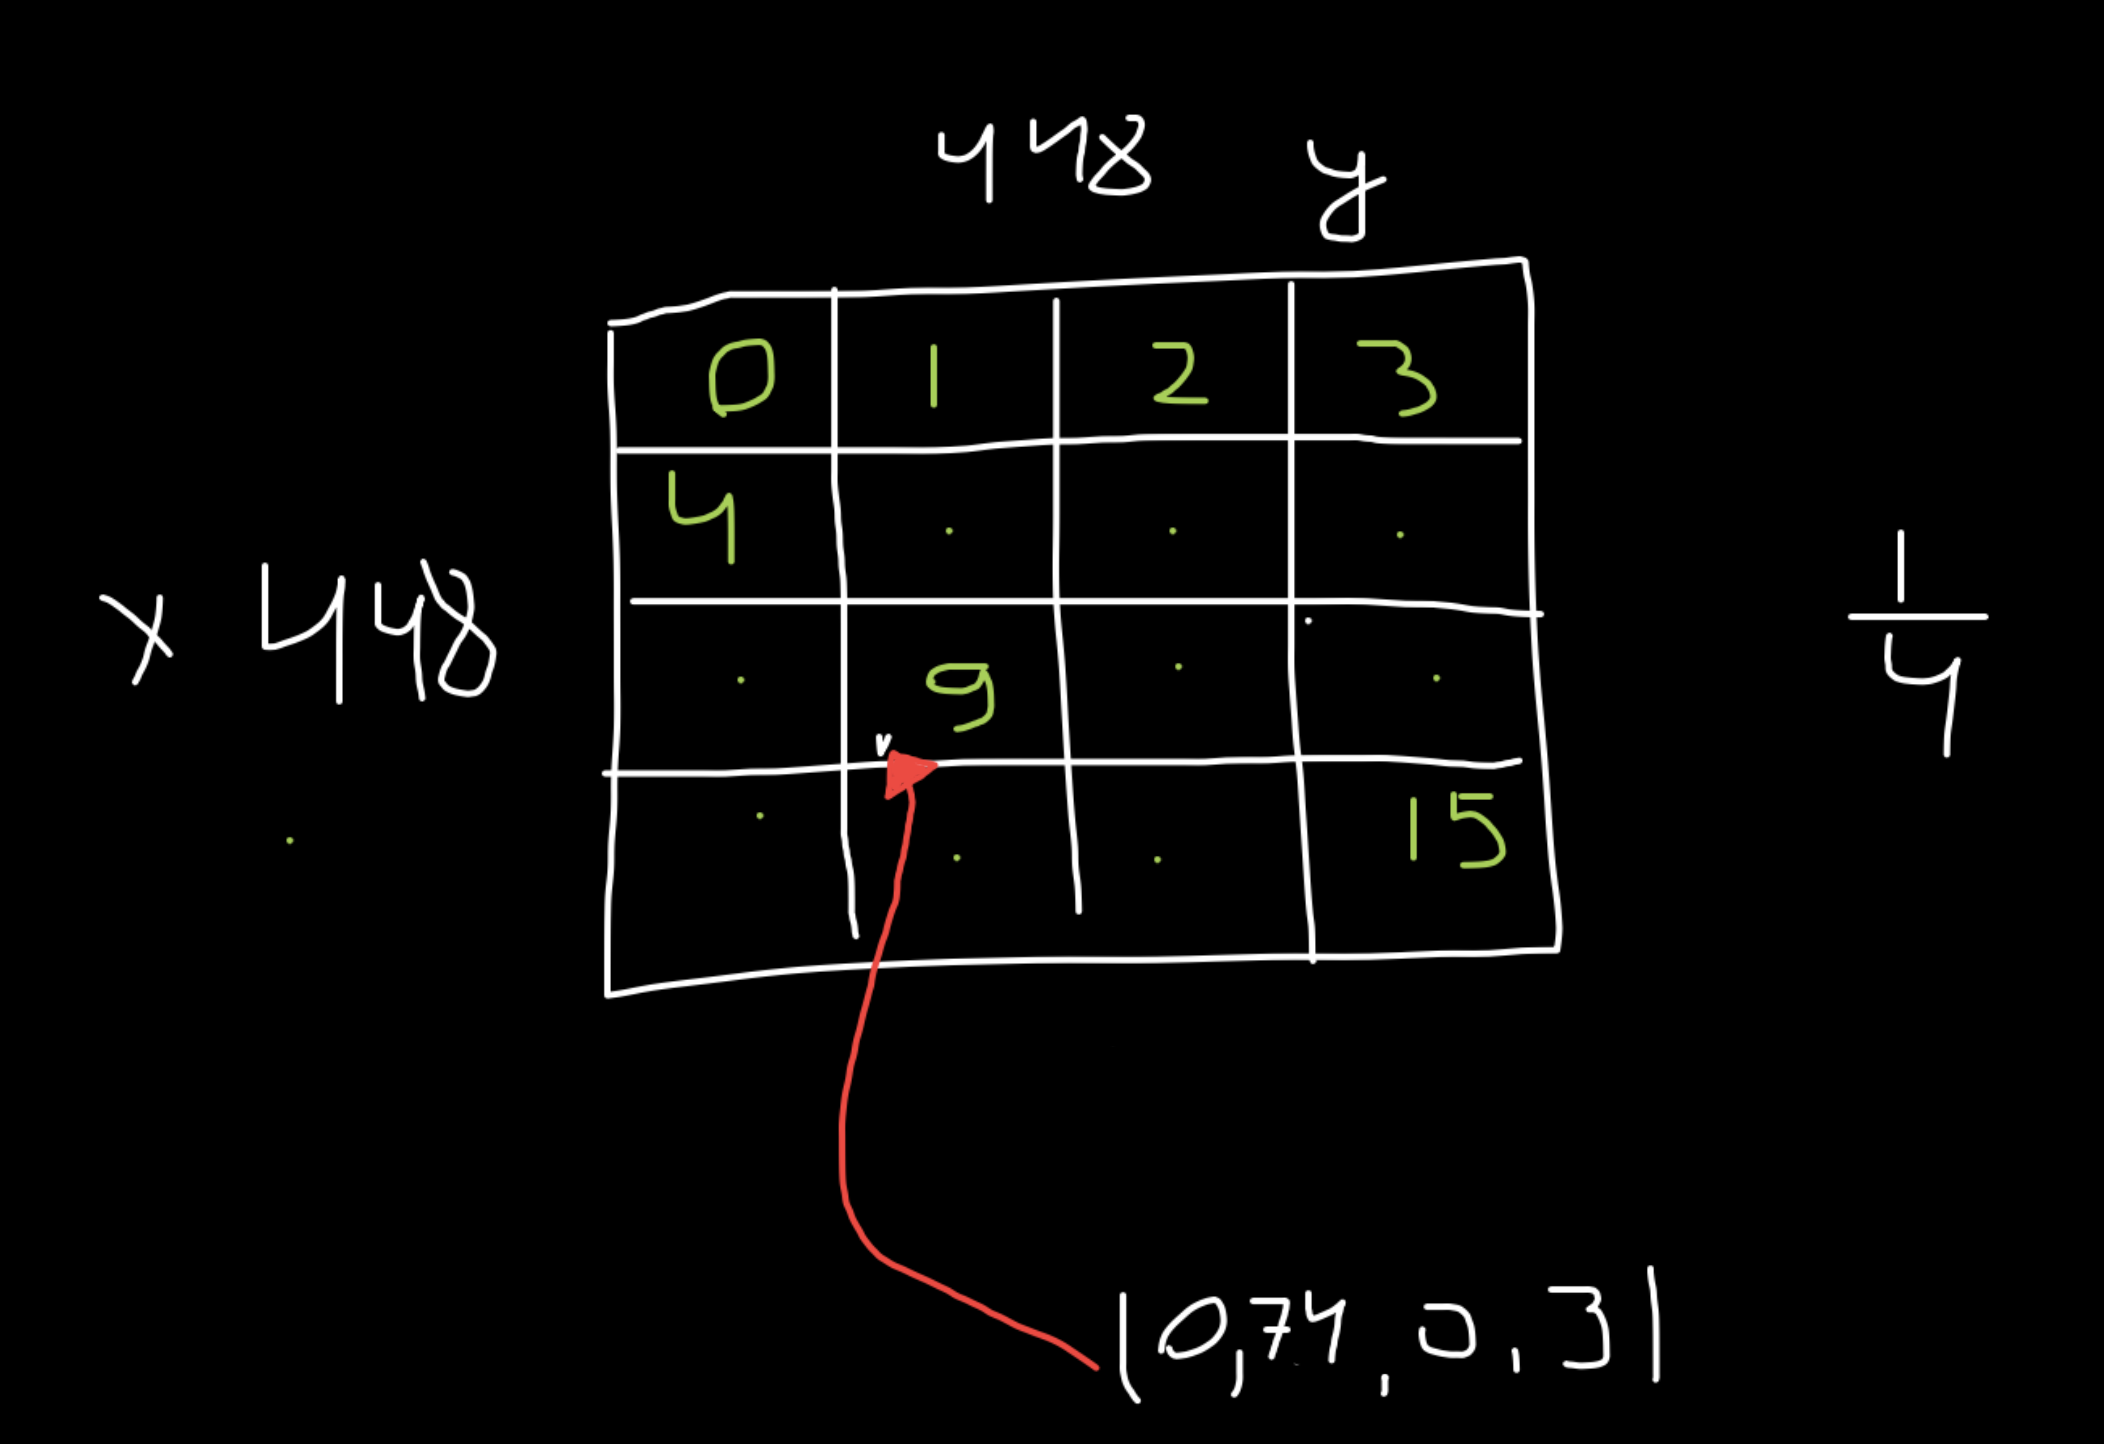

In [6]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.image_paths = sorted([data_dir + '/' + image_path for image_path in os.listdir(data_dir) if image_path[-3:]=="jpg"])
        self.box_paths = sorted([data_dir + '/' + box_path for box_path in os.listdir(data_dir) if box_path[-3:]=="xml"])

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        w, h = image.shape[1], image.shape[0]
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx], w, h)
        if self.transforms:
          transformed = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
          image = transformed['image']
          boxes = transformed['bboxes']
          class_labels = transformed['class_labels']

        nedo_target = [0]*(7*7*(2*5+3)) # one cell takes 13 elements

        for i in range(0, len(boxes)):
          number_of_cell = self.which_cell(boxes[i][0], boxes[i][1])
          start = number_of_cell*13

          nedo_target[start:start+4] = boxes[i]
          nedo_target[start+4] = 1

          nedo_target[start+5: start+9] = boxes[i]
          nedo_target[start+9] = 1

          class_distr = [0]*3
          class_distr[class_labels[i] - 1] = 1
          nedo_target[start+10: start+13] = class_distr

        target = torch.Tensor(nedo_target)
        return image/255, target

    def which_cell(self, x, y, S=7):
      x_c, y_c = int(x / (1/S)), int(y / (1/S))
      return x_c*S + y_c

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str, w, h):
      """
      Метод, который считает и распарсит (с помощью xmltodict) переданный xml
      файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
      и название класса обьекта в каждом прямоугольнике

      Обратите внимание, что обьектов может быть как несколько, так и один единственный
      """
      boxes = []
      class_labels = []

      fileptr = open(xml_filename,"r")
      xml_content= fileptr.read()

      objects = xmltodict.parse(xml_content)['annotation']['object']

      if type(objects) is list:
        for obj in objects:
          boxes.append(self.__convert_to_yolo_box_params([int(obj['bndbox']['xmin']), int(obj['bndbox']['ymin']), 
                                                          int(obj['bndbox']['xmax']), int(obj['bndbox']['ymax'])],
                                                          int(w), 
                                                          int(h)))
          class_labels.append(class2tag[obj['name']])
      else:
        obj = objects
        boxes.append(self.__convert_to_yolo_box_params([int(obj['bndbox']['xmin']), int(obj['bndbox']['ymin']), 
                                                        int(obj['bndbox']['xmax']), int(obj['bndbox']['ymax'])],
                                                        int(w), 
                                                        int(h)))
        class_labels.append(class2tag[obj['name']])

      return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
      """
      Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
      
      Обратите внимание, что параметры [x_center, y_center, width, height] - это
      относительные значение в отрезке [0, 1]

      :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
      :param: im_w - ширина исходного изображения
      :param: im_h - высота исходного изображения

      :return: координаты коробки в формате [x_center, y_center, width, height]
      """
      ans = []
      ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
      ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
    
      ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
      ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
      return ans

In [7]:
from albumentations.pytorch import ToTensorV2

WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([A.Resize(width=WIDTH, height=HEIGHT),
                             A.OneOf([A.HorizontalFlip(p=0.1),
                             A.RandomBrightnessContrast(p=0.1),
                             A.RGBShift(p=0.1)], p=0.5),
                             ToTensorV2()],
                             bbox_params=A.BboxParams(format='yolo',
                                                      label_fields=['class_labels']))

test_transform = A.Compose([A.Resize(width=WIDTH, height=HEIGHT),
                            ToTensorV2()],
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [8]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [9]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False
    )

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [10]:
def convert_from_yolo_params(box_coordinates: List[int], im_w=448, im_h=448):
      """
      Перейти от [x_center, y_center, width, height] к [xmin, ymin, xmax, ymax].
      
      """
      ans = []

      absolute_width = box_coordinates[2] * im_w
      absolute_height = box_coordinates[3] * im_h

      ans.append((box_coordinates[0]*im_w) - (absolute_width/2))  # x_min
      ans.append((box_coordinates[1]*im_h) - (absolute_height/2))  # y_min
    
      ans.append((box_coordinates[0]*im_w) + (absolute_width/2))  # x_max
      ans.append((box_coordinates[1]*im_h) + (absolute_height/2))  # y_max
      return ans

In [11]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: dt_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]
    
    :return: Intersection Over Union
    """
    predicted_bbox = convert_from_yolo_params(predicted_bbox)
    gt_bbox = convert_from_yolo_params(gt_bbox)

    intersection_bbox = torch.Tensor(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

In [12]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        self.cnnblock1 = nn.Sequential( # 448 to 112
            CNNBlock(3, 64, kernel_size=(7, 7), padding='same'),
            nn.Dropout(),
            CNNBlock(64, 192, True, kernel_size=(7, 7),padding='same'),
            nn.Dropout(),
            CNNBlock(192, 256, True, kernel_size=(3, 3), padding='same'),
            nn.Dropout(),
        )

        self.cnnblock2 = nn.Sequential(# 112 to 56
            CNNBlock(256, 256, kernel_size=(3, 3), padding="same"),
            #nn.Dropout(),
            CNNBlock(256, 512, True, kernel_size=(3, 3), padding='same'),
            #nn.Dropout()
        )

        self.cnnblock3 = nn.Sequential(# 56 to 28
            CNNBlock(512, 256, kernel_size=(1, 1), padding="same"),
            #nn.Dropout(),
            CNNBlock(256, 512, True, kernel_size=(3, 3), padding='same'),
            #nn.Dropout(),
        )

        self.cnnblock4 = nn.Sequential(# 28 to 14
            CNNBlock(512, 256, kernel_size=(1, 1), padding="same"),
            #nn.Dropout(),
            CNNBlock(256, 512, True, kernel_size=(3, 3), padding='same'),
            #nn.Dropout(),
        )

        self.cnnblock5 = nn.Sequential(# 14 to 7
            CNNBlock(512, 1024, kernel_size=(3, 3), padding="same"),
            #nn.Dropout(),
            CNNBlock(1024, 512, True, kernel_size=(1, 1), padding='same'),
            #nn.Dropout()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 512, 1024),
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(1024, S*S*(B*5+C)),
        )

    def forward(self, x):

      x = self.cnnblock1(x)
      x = self.cnnblock2(x)
      x = self.cnnblock3(x)
      x = self.cnnblock4(x)
      x = self.cnnblock5(x)
      return self.classifier(x)


temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (temp_model.B * 5 + temp_model.C)

assert temp_model(train_dataset[0][0].unsqueeze(0)).reshape(-1).shape[0] == expected_output_shape

In [13]:
temp_model(train_dataset[0][0].unsqueeze(0))

tensor([[ 2.7749e-01, -6.4369e-01, -9.2501e-03, -2.6076e-01,  5.7347e-01,
         -9.5254e-02,  6.4461e-01, -1.2930e-01, -6.1378e-01,  2.7144e-01,
          3.8747e-01,  1.5857e-01, -2.7496e-01, -1.2161e-01, -6.0894e-01,
          2.5637e-01,  7.9140e-02, -3.7739e-02,  4.7433e-02,  2.1918e-01,
         -1.2491e-01,  5.2101e-01,  6.4369e-02,  6.2913e-02,  4.8292e-01,
         -4.8006e-01, -4.4244e-01,  3.7874e-01, -2.3624e-01, -4.1311e-02,
         -5.0505e-01, -1.6746e-01,  3.3321e-01, -1.4695e-01,  3.1385e-02,
          6.1530e-01, -4.9582e-02, -3.0140e-02, -6.7002e-02,  6.0072e-01,
          2.5852e-01,  4.0805e-01,  1.2834e-03,  2.9645e-01, -1.8900e-01,
         -1.5140e-01, -3.6507e-01,  1.1338e-01,  3.5678e-01, -8.8127e-01,
          1.1909e-01,  3.1803e-01,  4.5283e-01, -1.7270e-01,  1.2991e-01,
          3.3032e-01, -2.9646e-01,  4.7142e-02, -3.4507e-01, -8.7370e-02,
         -7.6785e-02, -1.9892e-01,  2.7818e-01,  2.7332e-01,  1.0322e-01,
          8.1776e-02,  1.6749e-01, -1.

## Реализуйте YoloLoss - 3 балла

In [14]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
      loss = 0
      for batch in range(len(predictions)):
        for i in range(0, self.S*self.S):
          if target[batch][i*13+5-1] < 0.5: # if C == 0 
            for j in range(0, self.B):
              loss += self.lambda_noobj * self.mse(predictions[batch][i*13+(5*(j+1)-1)], 
                                                  target[batch][i*13+(5*(j+1)-1)])
          else:
            loss += self.mse(predictions[batch][i*13+10:i*13+13], target[batch][i*13+10:i*13+13])
            resp_box, max_iou = 0, 0 

            for j in range(0, self.B): # Finding responsible box
              iou = intersection_over_union(predictions[batch][i*13+5*j:i*13+(5*(j+1)-1)], 
                                            target[batch][i*13+5*j:i*13+(5*(j+1)-1)])
              if iou >= max_iou:
                resp_box = j
                max_iou = iou

            for j in range(0, self.B):
              if j == resp_box:
                loss += self.lambda_coord * self.mse(predictions[batch][i*13+5*j],                        # x_pred - x_true
                                                  target[batch][i*13+5*j])
                loss += self.lambda_coord * self.mse(predictions[batch][(i*13+5*j) + 1],                  # y_pred - y_true
                                                  target[batch][(i*13+5*j) + 1])
                
                w_pred, w_true = predictions[batch][(i*13+5*j) + 2], target[batch][(i*13+5*j) + 2]               # w_pred - w_true
                loss += self.lambda_coord * self.mse(torch.sqrt(abs(w_pred)) * (w_pred)/ abs(w_pred), 
                                                  torch.sqrt(abs(w_true)) * (w_true)/ abs(w_true))
                
                h_pred, h_true = predictions[batch][(i*13+5*j) + 3], target[batch][(i*13+5*j) + 3]               # h_pred - h_true
                loss += self.lambda_coord * self.mse(torch.sqrt(abs(h_pred)) * (h_pred)/ abs(h_pred), 
                                                  torch.sqrt(abs(h_true)) * (h_true)/ abs(h_true))
                
                loss += self.lambda_coord * self.mse(predictions[batch][(i*13+5*j) + 4],                   # C_pred - C_true
                                                  target[batch][(i*13+5*j) + 4])
              else:
                loss += self.lambda_noobj * self.mse(predictions[batch][i*13+(5*(j+1)-1)], 
                                                  target[batch][i*13+(5*(j+1)-1)])
        
      return loss

## Реализуйте дополнительные функции из статьи - 2 балла

In [15]:
def non_max_suppression(bboxes, iou_threshold = 0.05, threshold=0.9):
    good_format_boxes = torch.zeros(49*2, 8)
    counter = 0
    for i in range(49):
      good_format_boxes[counter] = torch.cat((bboxes[i*13:i*13+5], bboxes[i*13+10:i*13+13]))
      good_format_boxes[counter + 1] = torch.cat((bboxes[i*13+5:i*13+10],bboxes[i*13+10:i*13+13]))
      counter += 2

    good_boxes = []
    good_format_boxes = good_format_boxes.tolist()
    for box in good_format_boxes:
      if box[4] > threshold:
        good_boxes.append(box)

    good_boxes.sort(key=lambda C: C[4])
    best_boxes = []

    counter = 0
    while good_boxes:
      best_boxes.append(good_boxes.pop())
      for i in range(len(good_boxes) - 1, -1, -1):
        iou = intersection_over_union(good_boxes[i][:4], best_boxes[counter][:4])
        if iou > iou_threshold:
          good_boxes.pop(i)


    return best_boxes



def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5):
    ## YOUR CODE
    pass

def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4):
    ## YOUR CODE
    return all_pred_boxes, all_true_boxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [16]:
class YOLOLearner(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()

        self.model = YOLO()
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=5e-4)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma = 0.975)
        return [self.optimizer], [scheduler]

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, targets = train_batch
        preds = self.model(images)
        loss = self.loss(preds, targets)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, targets = val_batch
        preds = self.model(images)
        loss = self.loss(preds, targets)
        self.log('val_loss', loss, prog_bar=True)

In [17]:
n_epochs = 20
device = "cuda:0" if torch.cuda.is_available() else "cpu"

yolo_learner = YOLOLearner().to(device)

device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(accelerator=device, max_epochs=n_epochs)

trainer.fit(yolo_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 37.0 M
1 | loss  | YoloLoss | 0     
-----------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
148.179   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [59]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
#torch.save(model.state_dict(), "/content/drive/MyDrive/models/model_yolov1_weights.pth")

In [ ]:
#saved_model = YOLOLearner()
#saved_model.load_state_dict(torch.load("/content/drive/MyDrive/models/model_yolov1_weights.pth"))

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [19]:
model = yolo_learner.to("cpu")

In [190]:
image, targets = val_dataset[41]
preds = non_max_suppression(yolo_learner.model(image.unsqueeze(0)).squeeze(0), 0.4, 0.65)

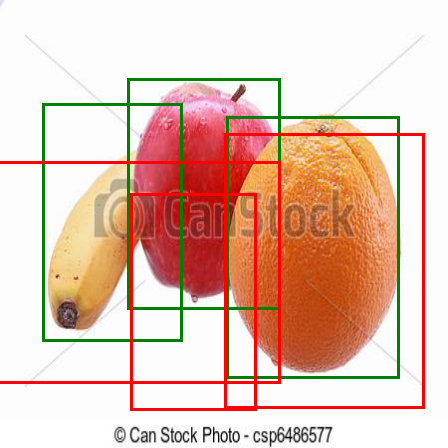

In [191]:
from PIL import ImageDraw

result6 = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(result6)

i = 0
while i < len(targets):
  if targets[i] != 0:
    x1, y1, x2, y2 = convert_from_yolo_params([targets[i], targets[i+1], targets[i+2], targets[i+3]])
    draw.rectangle([(x1, y1), (x2, y2)], outline='green', width=3)
    i += 11
  i += 1


for b in preds:
    box = convert_from_yolo_params(b[:4])
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red', width=3)
result6

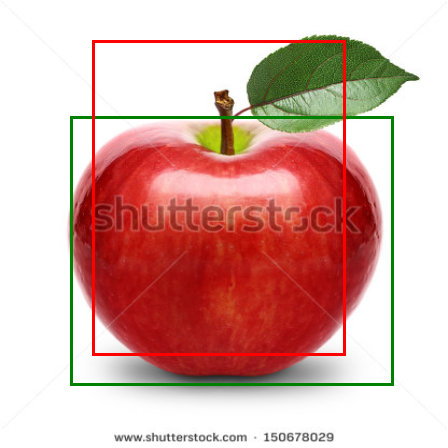

In [94]:
result1 #5

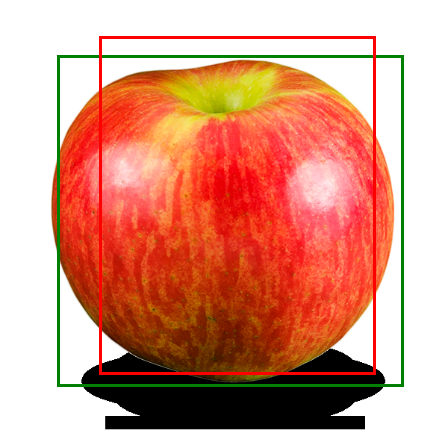

In [95]:
result2 #15

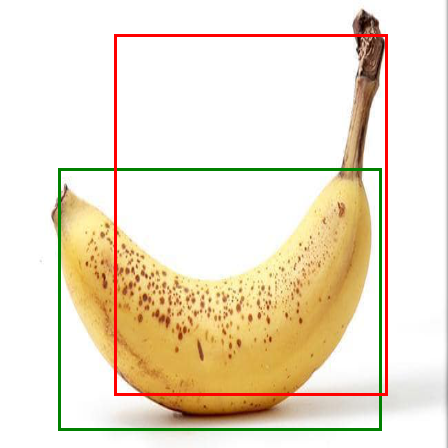

In [103]:
result3 # 26

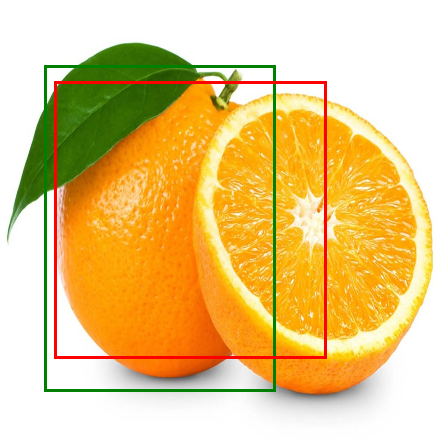

In [128]:
result4 # 45

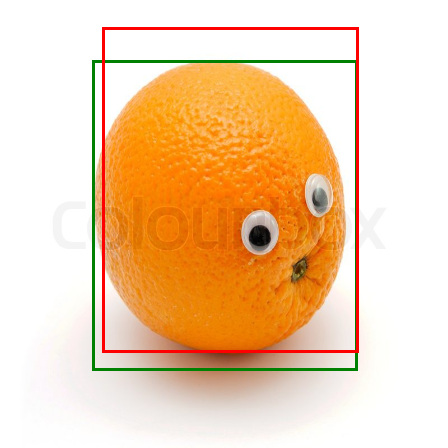

In [135]:
result5 # 55

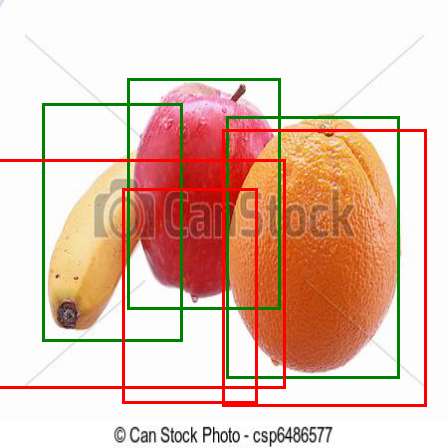

In [171]:
result6 #41

# **Заключение**

> В конечном итоге получилось реализовать модель yolov1 по всем канонам из статьи (Конечно же пришлось немного подкорректировать модель, в связи с огромным количеством параметром, так что моя модель даже ближе к yolov1_fast version) 

> Удалось добиться лосса на валидации = 29.00. Однако стоит учесть, что в своей функции я не использовал усреднее по батчу => лосс на одной картинке = 29/4. В целом, этого хватило, чтобы получить сносный результат детекции на валидационном сете (картинки выше)

> Модель хорошо справляется с детекцией одного объекта, однако когда объектов несколько возникают трудность, но так или иначе в большинстве случаев модель предсказывает правильное количество боксов (объектов) и немного ошибается с их расположением. Я считаю, что для этого дз - это успех, ведь не было цели добиться идеального результата, превращая всю работу в сплошной тюннинг параметров - слова автора. Главное было показать, что модель работает и следовательно лосс, датасет и все остальное было написано верно (Хотя подбирать архитектуру, аугментации, шаг, шедулер, тоже пришлось немало)

> Касаемо лосса, намерено написал его в виде циклов, для более наглядного вида, чтобы это выглядело ровно как в статье!

> Касаемо, минусов, не реализовал функцию MaP - на самом деле, потому что убил слишком много времени на дз и уже просто не хватает времени, ведь есть еще уйма других дедлайнов. Функция get_bound_boxes() по моему мнению не имеет особого смысла, ведь у меня все написано так, что после NMS сразу получаются коробочки в прекрасном и удобном формате, а из таргета достать коробки совершенно не проблема.

> Итого, для демонстрации результата я взял максимально разные картинки (яблоки, бананы, апельсины, все вместе), также хочу отметить, что я не читерил и для всех из них использовал одни  и те же пороги в NMS, я сохранил веса - поэтому при желании можно будет это проверить! Все получилось, все работает, я доволен!









